In [2]:
!pip3 install -U scikit-learn
!pip3 install torch torchvision torchaudio
!pip3 install pickle


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

import pickle 

Unpacking the data

In [2]:
with open('../data/sampled_filters_train.pkl', 'rb') as f:
    data = pickle.load(f)


In [14]:
wavelengths = data['wavelengths']
spectra = data['spectra']
z = data['z']
df_X = pd.DataFrame(data['X'])
outlier_columns = df_X.columns[df_X.eq(58.9).any(axis = 0)]
df_X = df_X.drop(outlier_columns, axis = 1)
X = df_X.to_numpy()

scaler = StandardScaler()
#X_normalized = np.array([list(scaler.fit_transform(torch.tensor(X[i]).reshape(-1, 1)).reshape(1, -1)) for i in range(len(X))]).squeeze()
X_normalized = scaler.fit_transform(df_X)

names=data['filter_names']
filter_wls = [int(name[1:-1].rstrip('W')) for name in names]
filter_wls = [element for i, element in enumerate(filter_wls) if i not in outlier_columns]
indices=[0,10,30,500,15000,800000]

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


define network

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class SingleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, (diff + 1) // 2))
        x = torch.cat([x2, x1], dim=1)

        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.convOut = nn.Conv1d(64, 1, kernel_size = 1)

        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x3 = self.up2(x4, x3)
        x2 = self.up3(x3, x2)
        x1 = self.up4(x2, x1)
        x = self.convOut(x1)
        return x


Add Noise

In [37]:
def add_noise(X, t, T = 100):

    #beta0, betaT = 0.0001, 0.2
    beta_t = np.array([0.0001 * (1.05**i) for i in range(T)])
    
    
    alpha = [1-beta_t[i] for i in range(len(beta_t))]
    alpha_bar = np.prod(alpha[:t-1])
    
    mu, sigma = math.sqrt(alpha_bar) * X, (1 - alpha_bar) * np.identity(len(X))
    X_tm1 = np.random.multivariate_normal(mu, sigma)
    mu, sigma = math.sqrt(1 - beta_t[T-1]) * X_tm1, (beta_t[T-1]) * np.identity(len(X_tm1))
    X_t = np.random.multivariate_normal(mu, sigma)
    pred_noise =  X_t - X_tm1
    return list(X_t), list(pred_noise)

def gen_dataset(data):
    dataset = {
        "X_t": [],
        "X_tm1": []
    }

    for d in data:
        t = random.randint(1, 100)
        X_t, X_tm1 = add_noise(d, t)
        dataset["X_t"].append(X_t)
        dataset["X_tm1"].append(X_tm1)
    dataset["X_t"] = np.array(dataset["X_t"])
    dataset["X_tm1"] = np.array(dataset["X_tm1"]) 
    return dataset

class MyDataset(Dataset):
    def __init__(self, data_dict):
        self.data_dict = data_dict
        self.keys = list(data_dict.keys())
        self.length = len(data_dict[self.keys[0]])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        data = {key: self.data_dict[key][index] for key in self.keys}
        return data
    
def print_metaData(n, batch_size):
    print(n, batch_size)

Define model

In [13]:
model = UNet().double().to(device)
model.parameters()

<generator object Module.parameters at 0x000001C6758653F0>

Training

In [15]:
n = 64000
batch_size = 64

#loss
loss_fn = nn.MSELoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

#loss data
running_loss_arr = np.array([])



EPOCHS = 2
#training
model.train(True)
for epoch in range(EPOCHS):
    # generate data_loader
    dataset = MyDataset(gen_dataset(X_normalized[0:n]))
    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    
    
    print('EPOCH ', epoch, ":")
    
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        X_t, X_tm1 = data.values()
        X_t = X_t.unsqueeze(1).double().to(device)
        X_tm1 = X_tm1.unsqueeze(1).double().to(device)
        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(X_t)
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, X_tm1)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            last_loss = running_loss / 100 # loss per batch
            tb_x = epoch * len(train_dataloader) + i + 1
            running_loss_arr = np.append(running_loss_arr, [tb_x, last_loss])
            running_loss = 0.

    scheduler.step()

    print('LOSS train: ', running_loss_arr[-1])

model.train(False)


EPOCH  0 :
LOSS train:  0.008564734641162995
EPOCH  1 :
LOSS train:  0.00841941584211418


UNet(
  (conv): DoubleConv(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (down1): Down(
    (conv): DoubleConv(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Down(
    (conv): D

In [16]:
torch.save(model.state_dict(), 'model_param.pt')
df_loss = pd.DataFrame({"time": running_loss_arr.reshape(-1, 2).transpose()[0], "loss": running_loss_arr.reshape(-1, 2).transpose()[1]})
df_loss.to_csv('losses.csv', index = False)

Print output of model

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 31])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss:  tensor(0.0141)


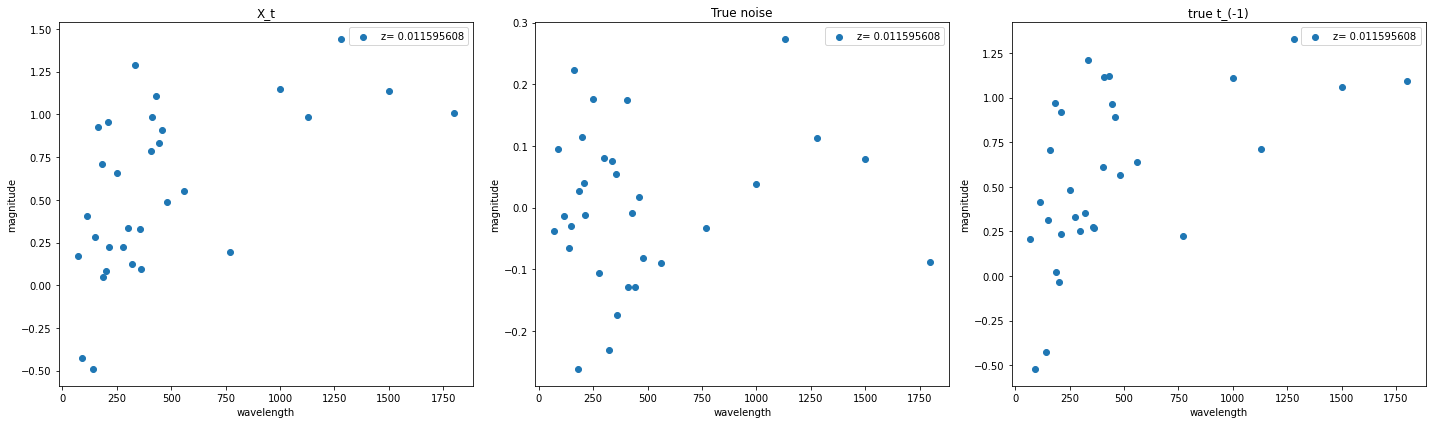

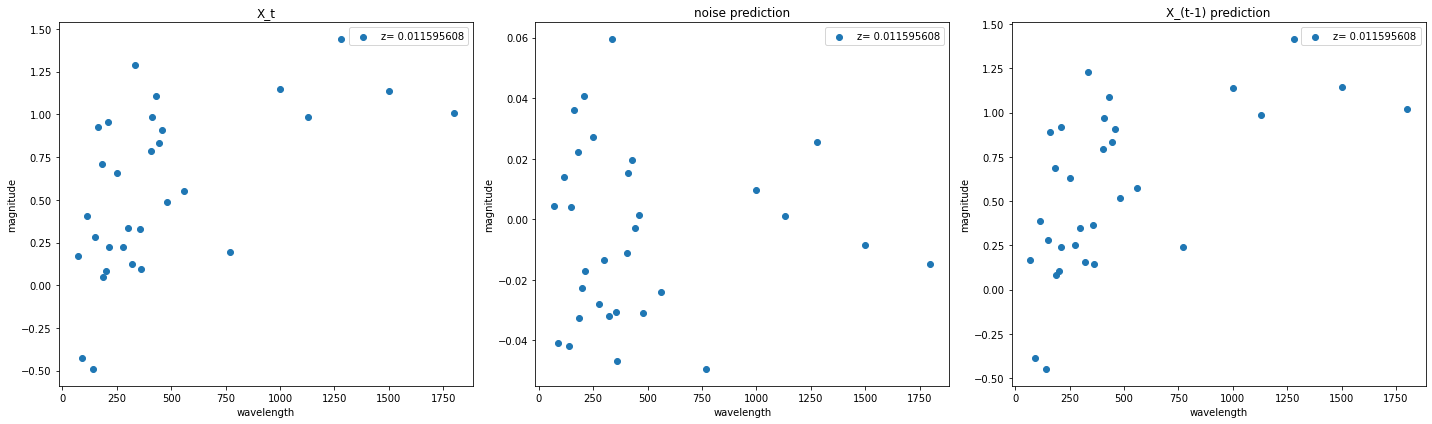

In [38]:
p1 = random.randint(0, 100)

X_t, noise = add_noise(X_normalized[0], t = 80)
X_tm1 = np.array(X_t) - np.array(noise)


noise_pred = model(torch.tensor(X_t).unsqueeze(0).unsqueeze(0).to(device)).cpu().detach().numpy()
X_tm1_pred = np.array(X_t) - noise_pred

loss_fn = nn.MSELoss()
loss = loss_fn(torch.tensor(noise).float(), torch.tensor(noise_pred).float())
print("loss: ", loss)


plt.figure(figsize= (20, 6))

plt.subplot(1, 3, 1)
plt.title('X_t')
plt.scatter(filter_wls, X_t, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 2)
plt.title('True noise')
plt.scatter(filter_wls, noise, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 3)
plt.title('true t_(-1)')
plt.scatter(filter_wls, X_tm1, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize= (20, 6))

plt.subplot(1, 3, 1)
plt.title('X_t')
plt.scatter(filter_wls, X_t, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 2)
plt.title('noise prediction')
plt.scatter(filter_wls, noise_pred, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 3)
plt.title('X_(t-1) prediction')
plt.scatter(filter_wls, X_tm1_pred, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
print(np.mean(X_t))
print(np.std(X_t))
print(np.mean(np.random.multivariate_normal(mu, sigma)))
print(np.std(np.random.multivariate_normal(mu, sigma)))

0.5646465864942138
0.4792312318189288
-0.013397975732608189
0.7861220444445817


In [26]:
def denoise(X, T = 100):
    X = torch.tensor(X).unsqueeze(0).unsqueeze(0).to(device)
    for _ in range(T):
        X_noise = model(X) 
        X = X - X_noise
    return X

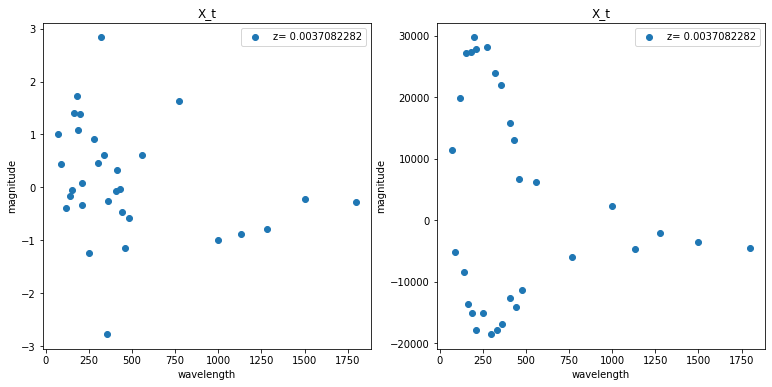

In [29]:
mu, sigma = np.zeros(31), np.identity(31)
X_t = np.random.multivariate_normal(mu, sigma)
X_t_denoise = denoise(X_t).cpu().detach()

plt.figure(figsize= (20, 6))

plt.subplot(1, 3, 1)
plt.title('X_t')
plt.scatter(filter_wls, X_t, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 3, 2)
plt.title('X_t')
plt.scatter(filter_wls, X_t_denoise, label = "z= "+str(z[p1,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

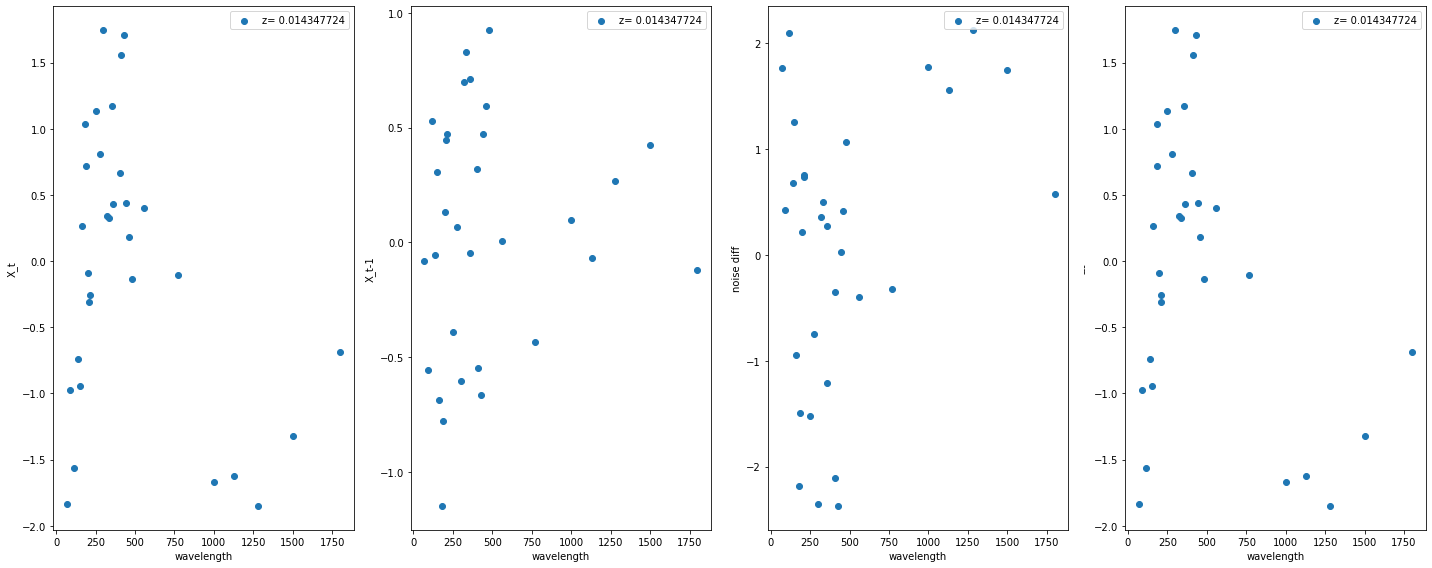

In [147]:
a, b = add_noise(X_normalized[4], T = 1)
c = np.array(b) - np.array(a)
d = np.array(b) - c

plt.figure(figsize= (20, 8))

plt.subplot(1, 4, 1)
plt.scatter(filter_wls, a, label = "z= "+str(z[0,0]))
plt.ylabel("X_t")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 4, 2)
plt.scatter(filter_wls, b, label = "z= "+str(z[0,0]))
plt.ylabel("X_t-1")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 4, 3)
plt.scatter(filter_wls, c, label = "z= "+str(z[0,0]))
plt.ylabel("noise diff")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 4, 4)
plt.scatter(filter_wls, d, label = "z= "+str(z[0,0]))
plt.ylabel("---")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()


plt.tight_layout()
plt.show()


In [49]:
X[0]

array([20.786884, 20.960768, 21.265028, 21.509062, 21.601727, 21.808668,
       58.9     , 21.899237, 21.870485, 22.042837, 22.1664  , 22.201782,
       22.337282, 22.382853, 22.393621, 22.491522, 22.391426, 22.527351,
       22.557444, 22.61449 , 22.445515, 22.539598, 22.658358, 22.670202,
       22.752363, 58.9     , 58.9     , 22.814674, 22.803913, 23.091652,
       23.25525 , 23.325388, 23.654198, 24.586325, 24.331484, 25.391253,
       25.81203 ], dtype=float32)

In [50]:
X0

array([18.18387858, 19.11158712, 18.77033567, 18.73173945, 19.83147745,
       19.76799058, 52.53073971, 19.24033204, 19.82485043, 19.58854701,
       19.18816197, 20.34733135, 19.80594306, 20.61285027, 20.00532452,
       19.72817818, 20.04521396, 20.65350765, 20.20638097, 19.88978372,
       20.32575284, 19.93396853, 20.56848211, 20.20734979, 20.52066788,
       52.92152031, 52.14634073, 20.77923495, 20.89681471, 21.11384064,
       21.1684129 , 21.25573751, 21.35002085, 21.63235812, 22.5197138 ,
       22.67553267, 23.9491519 ])